# The Max Cut Problem

The Max Cut problem is one of the most famous problems in combinatorial optimization. Given
an undirected graph G(V, E) with a vertex set V and an edge set E, the Max Cut problem seeks to
partition V into two sets such that the number of edges between the two sets (considered to be
severed by the cut), is a large as possible.  (https://arxiv.org/pdf/1811.11538)

We will visualize and solve a basic example in this notebook

Graph with 5 nodes and 6 edges


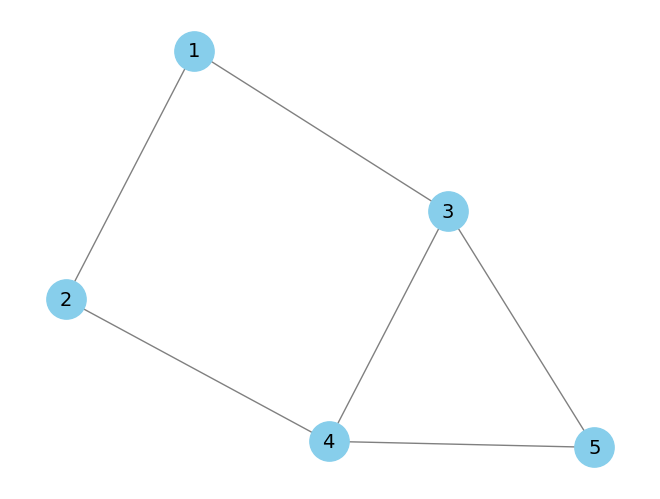

In [36]:
import networkx as nx
import matplotlib as plt


# First we will create an arbitrary Graph
G = nx.Graph()
G.add_edge(1, 2)
G.add_edge(1, 3)
G.add_edge(2, 4)
G.add_edge(3, 4)
G.add_edge(3, 5)
G.add_edge(4, 5)

print(G)
pos = nx.spring_layout(G, seed=1)  # consistent visuals
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=800, font_size=14)

## Defining The Problem 

We want to Maximize the number of edges that connect two nodes that are in seperate groups (either 0 or 1). For example if we put node 1 in group 0 and node 2 in group 1 E(1, 2) would be considered in the cut. Now how do we formulate this mathematically?

$y = \sum_{(i, j) \in E} (x_i + x_j - 2x_ix_j)$

Now what does the notation above actually mean? This looks fancy but really all we are doing is checking adding one to the total sum if $x_i$ and $x_j$ are different and doing nothing if they are the same.

### Example
Say we have node $x_i$ in group 0 and $x_j$ in group 1, for this particular instance the equation becomes (1 + 0) - 2 * 1 * 0 or just 1. Let's look at the other possibilities for closure.

#### Both in 0:   0 + 0 - 2 * 0 * 0 = 0  
#### Both in 1:   1 + 1 - 2 * 1 * 1 = 0

This is essentially just an XOR equivalent, but we have to use fancy math in order to put it in a quadratic format, so that we can optimize


# Building a Q matrix

Now that we have a definition of our problem we neet to remember our ultimate goal of formulating the problem as $y = x^TQx$. Where x are the binary inputs (in this case a random grouping of the edges) and Q is the matrix which represents the actual equation. Let's construct by hand for this simple example.

1. We have 5 variables one for each node (x1...x5)  
Original Matrix  
\## x1  x2 x3 x4 x5  
x1 [0, 0, 0, 0, 0]  
x2 [0, 0, 0, 0, 0]  
x3 [0, 0, 0, 0, 0]  
x4 [0, 0, 0, 0, 0]  
x5 [0, 0, 0, 0, 0]

2. Let's look at the formula for the first edge in the matrix: $x_1 + x_2 - 2 * x_1 * x_2$
3. For each term we can add the coefficient to the corresponding position in the matrix  
$Q_{11} += 1$  
$Q_{00} += 1$  
$Q_{01} -= 2$  
$Q_{10} -= 2$  

4. After applying all edges:  
$
Q =
\begin{bmatrix}
\boxed{2} & -2 & -2 &  0 &  0 \\
-2 & \boxed{2} &  0 & -2 &  0 \\
-2 &  0 & \boxed{3} & -2 & -2 \\
0 & -2 & -2 & \boxed{3} & -2 \\
0 &  0 & -2 & -2 & \boxed{2}
\end{bmatrix}
$
> NOTE: In the paper the values are set to -1 instead of -2, both approaches are valid, but differ in the final computation. The matrix is symmetric so if you use both sides of the matrix it is best to divide by 2.

- **Diagonal values** represent how many times each node appears in edges (they come from \( x_i \) and \( x_j \) terms).
- **Off-diagonal values** are \(-2\) for every edge between \( i \) and \( j \), due to the \( -2 x_i x_j \) term.
- This matrix is now suitable to be plugged into QUBO-based optimization frameworks like Qiskit, D-Wave, or custom solvers.


In [37]:
import numpy as np

Q = np.zeros((5, 5))
edges = [(0, 1), (0, 2), (1, 3), (2, 3), (2, 4), (3, 4)] # transformed to zero indexed 

for i, j in edges:
    Q[i][i] += 1
    Q[j][j] += 1
    Q[i][j] -= 2
    Q[j][i] -= 2

print(Q)

[[ 2. -2. -2.  0.  0.]
 [-2.  2.  0. -2.  0.]
 [-2.  0.  3. -2. -2.]
 [ 0. -2. -2.  3. -2.]
 [ 0.  0. -2. -2.  2.]]


## Note

Below I am using Quadratic program to try to keep this generalizeable to any QUBO problem, in reality there are much cleaner ways to solve the max-cut problem in the qiskit_optimization documentation: https://qiskit-community.github.io/qiskit-optimization/

In [38]:
from qiskit_optimization import QuadraticProgram

#Create a general Quadratic Program
cut = QuadraticProgram("Max-Cut")

#add binary variables
cut.binary_var('x0')
cut.binary_var('x1')
cut.binary_var('x2')
cut.binary_var('x3')
cut.binary_var('x4')

linear = { f'x{i}': Q[i, i] for i in range(5) } # Terms along the diaganol

quadratic = { # Terms off diagonal
    (f'x{i}', f'x{j}'): Q[i, j]
    for i in range(5) for j in range(5)
    if i < j and Q[i, j] != 0 ### avoid double counting edges, unnecessary if you divided by two 
}

cut.maximize(linear= linear, quadratic= quadratic) # has optional input constant as well, no constant in this problem 

print(cut.prettyprint())


Problem name: Max-Cut

Maximize
  -2*x0*x1 - 2*x0*x2 - 2*x1*x3 - 2*x2*x3 - 2*x2*x4 - 2*x3*x4 + 2*x0 + 2*x1
  + 3*x2 + 3*x3 + 2*x4

Subject to
  No constraints

  Binary variables (5)
    x0 x1 x2 x3 x4



## Solving

From my understanding there are now a few ways to approach this, the general idea is:


1. convert your quadratic program into an ising_hamiltonian
2. Choose the ansatz             
3. Choose the classical optimizer
4. Apply the variational solver 
5. Extract solution

I will not pretend to fully understand the tradeoffs between ansatzes or classical optimizers or variational solver's but below is an example of what this might look like, further research required in order to fully optimize these choices.

>it would appear that most of Quantum Algorithms package are not compatible with Qiskit 2.0, see requirements.txt for compatible packages

State, Probability
('10110', 0.974609375)


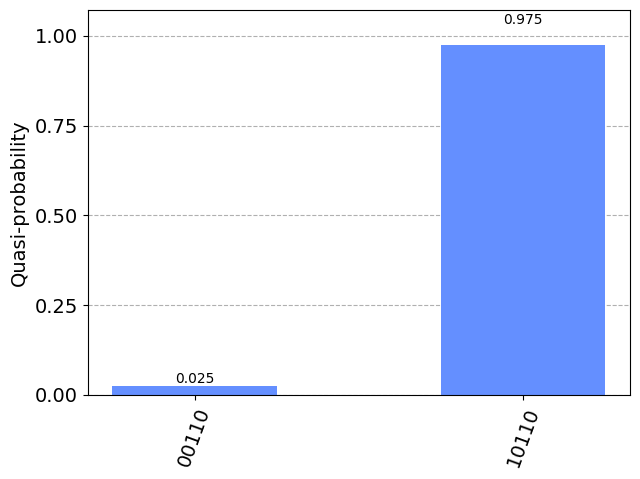

In [60]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram

hamiltonian, offset = cut.to_ising()
ansatz = RealAmplitudes(num_qubits=4, reps=2)
estimator = Estimator()
optimizer = SPSA()

vqe = VQE(estimator, ansatz, optimizer)

result = vqe.compute_minimum_eigenvalue(hamiltonian)
optimal_state = ansatz.assign_parameters(result.optimal_parameters)
optimal_state.measure_all()

sampler = Sampler(options={"shots": 1024})
distribution = sampler.run([optimal_state]).result().quasi_dists[0]

solution = max(distribution.binary_probabilities().items(), key=lambda x: x[1])
print("State, Probability")
print(solution)
plot_histogram(distribution.binary_probabilities())

In [ ]:
s = ''
for i, group in enumerate(reversed(solution[0])):
    s += f'{group}'
    print(f"Node {i}: {group}")

Node 0: 1
Node 1: 0
Node 2: 0
Node 3: 1
Node 4: 0


## Validate

In [61]:
def compute_cut_value(bitstring: str, G: nx.Graph) -> int:
    assignment = [int(bit) for bit in bitstring]
    cut_edges = 0
    for u, v in G.edges():
        if assignment[u] != assignment[v]:
            cut_edges += 1
    return cut_edges


print(compute_cut_value(s, G))

NameError: name 's' is not defined